In [ ]:
#  If you have issues with opencv install
#!pip install opencv-python
#!apt-get update && apt-get install ffmpeg libsm6 libxext6  -y

In [8]:
import numpy as np
import cv2
import PIL.Image
import matplotlib.pyplot as plt
import time

def load_image(img_path, out_size=500):
    img_orig = PIL.Image.open(img_path)
    # Resize image to out_size x out_size, ignore aspect ratio
    img = img_orig.resize((500,500), resample=PIL.Image.BILINEAR)
    # img = img_orig
    return img


def get_raw_saddle(gray_img):
    # Input image as np array, assume ~500 x 500 px image
    img = gray_img.astype(np.float64)
    # Blur image
    img = cv2.blur(img, (3,3)) # Blur it

    gx = cv2.Sobel(img,cv2.CV_64F,1,0)
    gy = cv2.Sobel(img,cv2.CV_64F,0,1)
    gxx = cv2.Sobel(gx,cv2.CV_64F,1,0)
    gyy = cv2.Sobel(gy,cv2.CV_64F,0,1)
    gxy = cv2.Sobel(gx,cv2.CV_64F,0,1)
    
    S = np.abs(gxx*gyy - gxy**2)
    return S


def nonmax_sup(img, win=10):
    """
    Perform non-maximum suppression on the given image.

    Parameters:
    img (numpy.ndarray): Input image array.
    win (int): The size of the window to consider for suppression. Default is 10.

    Returns:
    numpy.ndarray: Image array after non-maximum suppression.
    """

    # Assumes ~ 500x500 px image
    # Dilate the image to get the local maxima
    dilated = cv2.dilate(img, np.ones((2*win+1, 2*win+1), np.uint8))
    
    # Compare the original image to the dilated image
    local_max = (img == dilated)
    
    # Zero out the non-local maxima pixels
    img_sup = np.zeros_like(img, dtype=np.float64)
    img_sup[local_max] = img[local_max]
    
    return img_sup

def prune_saddle(x, thresh = 128, score_threshold = 10000):
    """
    Prune the saddle image x by thresholding in-place.
    x (numpy.ndarray): Input image array.
    """
    score = np.count_nonzero(x > 0)
    while score > score_threshold:
        thresh *= 2
        x[x < thresh] = 0
        score = np.count_nonzero(x > 0)

def get_saddle_pts(img):
    gray_img = np.array(img.convert('L'))

    start_time = time.time()
    saddle_img = get_raw_saddle(gray_img)
    raw_saddle = saddle_img.copy()
    prune_saddle(saddle_img) # Prune points (Reduces work later on)
    print(f'get_saddle took {time.time() - start_time:.3f} s')
    
    start_time = time.time()
    nonmax_saddle_img = nonmax_sup(saddle_img,10)
    print(f'nonmax_sup took {time.time() - start_time:.3f} s')

    start_time = time.time()
    pts = np.argwhere(nonmax_saddle_img)
    saddle_scores = nonmax_saddle_img[pts[:,0], pts[:,1]]
    ordering = np.argsort(saddle_scores)[::-1] # flip so highest first
    top_pts = pts[ordering] # ordered so strongest saddles first
    print(f'get_points took {time.time() - start_time:.3f} s')
    return top_pts, nonmax_saddle_img, raw_saddle

In [10]:
def run_on_image(img_path):
    img = load_image(img_path)

    top_pts, nonmax_saddle_img, raw_saddle = get_saddle_pts(img)
    
    plt.figure(figsize=(15,10))
    
    plt.subplot(131)
    plt.imshow(img, cmap='gray')
    plt.plot(top_pts[:,1], top_pts[:,0], 'ro')
    label_k = 50
    for i in range(len(top_pts[:label_k])):
        plt.text(top_pts[i,1], top_pts[i,0], i, color='white')
    plt.title(f'Found {len(top_pts)} saddle pts, labeling first {label_k} strongest')
    
    plt.subplot(132)
    plt.imshow(raw_saddle, cmap='gray')
    plt.title('original Saddle image')
    
    plt.subplot(133)
    plt.imshow(nonmax_saddle_img, cmap='gray')
    plt.title('Non-max Suppressed Pruned Saddle image')
    plt.tight_layout()
    plt.show()
    print('Done')

get_saddle took 0.017 s
nonmax_sup took 0.003 s
get_points took 0.001 s


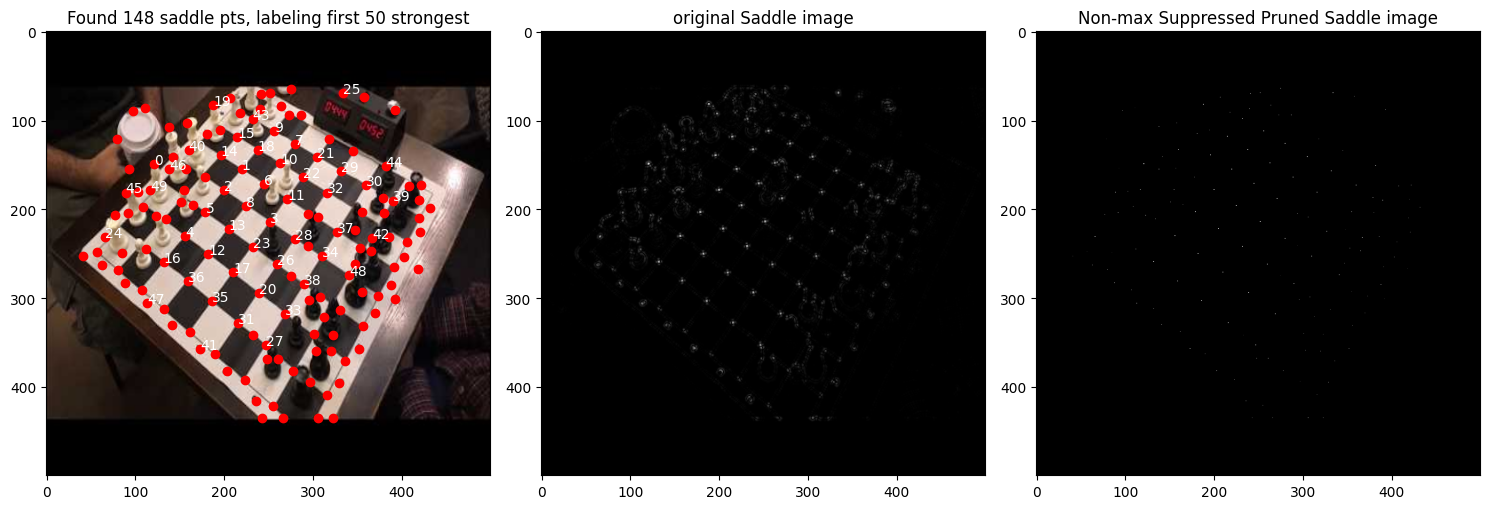

Done


In [11]:
run_on_image('0.jpg')

get_saddle took 0.009 s
nonmax_sup took 0.003 s
get_points took 0.001 s


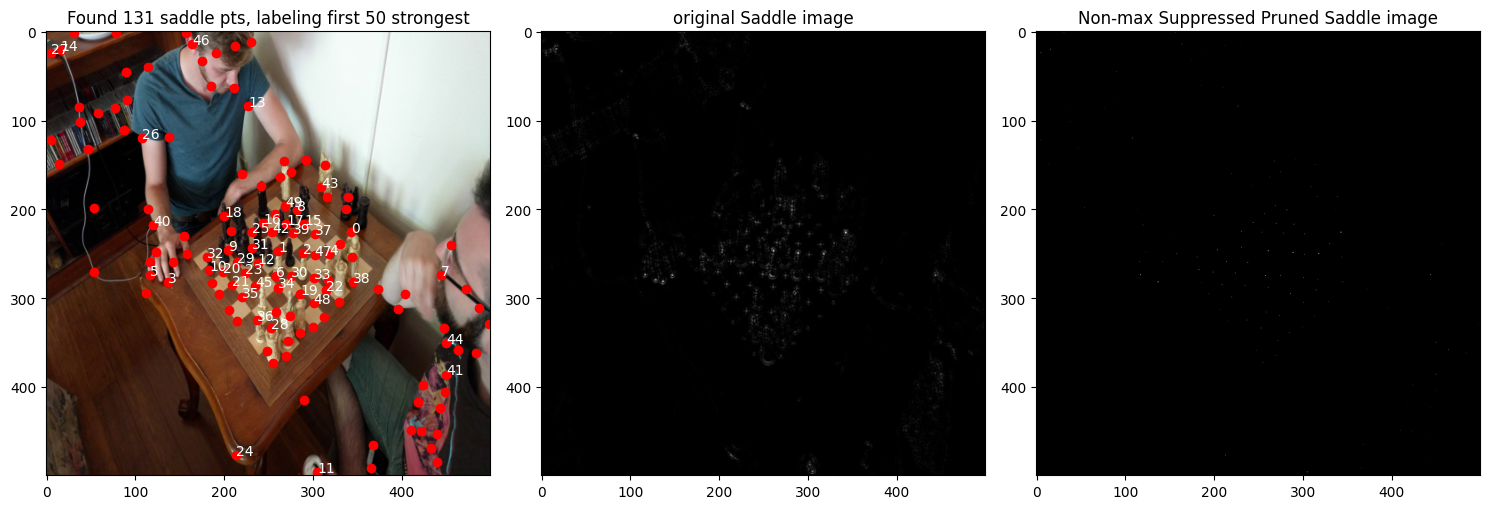

Done


In [12]:
run_on_image('1.jpg')

get_saddle took 0.012 s
nonmax_sup took 0.004 s
get_points took 0.002 s


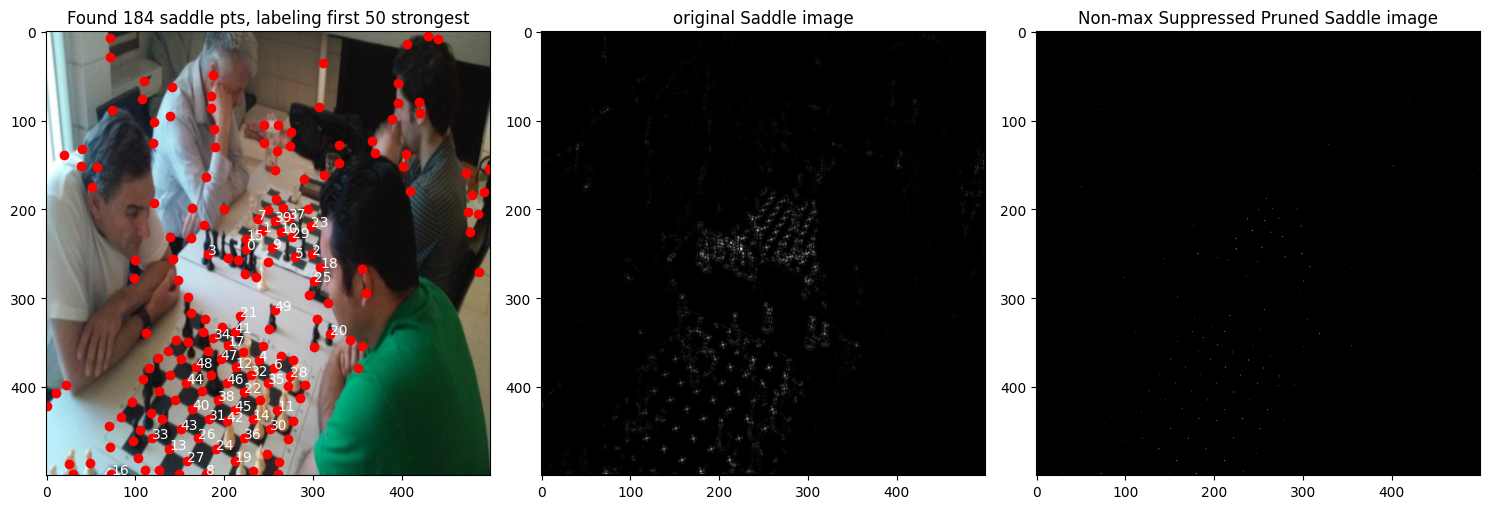

Done


In [13]:
run_on_image('2.jpg')